In [1]:
!nvidia-smi

Thu Nov 28 22:25:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   37C    P8               2W /  80W |   2693MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from utils import *

from tqdm import tqdm,trange
import torchvision.utils as vutils
from IPython.display import Image, display
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

In [3]:
class VAE_BatchPrep(BatchPrepareBase):
    def process(self, x):
        return x.cuda()

In [4]:
class VAE_Sampler(SamplerBase):

    def calc(self,model,num):
        return model.decode(torch.randn(num, model.latent_dim).cuda())
    
    @torch.no_grad()
    def sample(self, model, num, desc):
        x_data = next(iter(test_loader))[0][:num].cuda()
        
        # generation
        x = self.calc(model, num)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_gen.png')
        
        # reconstruction
        
        mu, logvar = model.encode(x_data)
        x_recon = model.decode(mu+torch.randn_like(mu)*torch.exp(logvar/2))
        grid = vutils.make_grid(x_recon, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_recon.png')
        grid = vutils.make_grid(x_data, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_data.png')
        
        torch.save(model.state_dict(), f'checkpoints/{desc}.pth')
        

In [5]:
class VAE_trainer(TrainerBase):
    def run(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = Avger(); rec_loss = Avger(); kl_loss = Avger()
            
            with tqdm(train_loader) as bar:
                for x,_ in bar:
                    inputs = self.preparer.process(x)
                    loss, rec, kl = self.model(inputs)
                    
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                    train_loss.append(loss.item()); rec_loss.append(rec.item()); kl_loss.append(kl.item())
                    bar.set_description(f'Epoch {epoch+1}/{self.epochs}, loss={train_loss}, rec={rec_loss}, kl={kl_loss}')
                    # break
                    
            if epoch == 0 or (epoch + 1) % self.sample_ep == 0 or epoch == self.epochs - 1:
                self.model.eval()
                self.sampler.sample(self.model, 64, f'ep{epoch+1}_{self.desc}')
                print(f'Epoch {epoch+1}, sample saved')

In [6]:
from vae import VAE
model = VAE().cuda()
# model = nn.DataParallel(model)
print('number of parameters:', sum(p.numel() for p in model.parameters()))
trainer = VAE_trainer(model, 50, 1e-3, 'vae', VAE_BatchPrep(), VAE_Sampler())
trainer.run()

number of parameters: 944600


Epoch 1/50, loss=53.7168, rec=53.3521, kl=0.3647: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 41.69it/s]


Epoch 1, sample saved


Epoch 4/50, loss=39.6837, rec=35.1181, kl=4.5656: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 78.15it/s]


Epoch 4, sample saved


Epoch 8/50, loss=33.9387, rec=27.5079, kl=6.4308: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 63.40it/s]


Epoch 8, sample saved


Epoch 9/50, loss=33.4738, rec=26.8732, kl=6.6006: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 64.83it/s]
Epoch 10/50, loss=33.0957, rec=26.4141, kl=6.6816: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 66.02it/s]
Epoch 11/50, loss=32.8235, rec=26.0441, kl=6.7794: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 51.89it/s]
Epoch 12/50, loss=32.5659, rec=25.7167, kl=6.8492: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 39.30it/s]


Epoch 12, sample saved


Epoch 13/50, loss=32.3718, rec=25.4718, kl=6.9000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 52.18it/s]
Epoch 14/50, loss=32.1876, rec=25.2300, kl=6.9575: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 49.39it/s]
Epoch 15/50, loss=32.0311, rec=25.0219, kl=7.0092: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 23.99it/s]
Epoch 16/50, loss=31.8560, rec=24.8084, kl=7.0476: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 48.14it/s]


Epoch 16, sample saved


Epoch 17/50, loss=31.7450, rec=24.6475, kl=7.0975: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 64.21it/s]
Epoch 18/50, loss=31.6006, rec=24.4735, kl=7.1271: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 80.15it/s]
Epoch 19/50, loss=31.5441, rec=24.3677, kl=7.1765: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 51.50it/s]
Epoch 20/50, loss=31.3983, rec=24.2170, kl=7.1813: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 38.54it/s]


Epoch 20, sample saved


Epoch 21/50, loss=31.3610, rec=24.1260, kl=7.2350: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 38.81it/s]
Epoch 22/50, loss=31.2379, rec=23.9875, kl=7.2504: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 53.54it/s]
Epoch 23/50, loss=31.1719, rec=23.8984, kl=7.2734: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 67.97it/s]
Epoch 24/50, loss=31.1058, rec=23.8062, kl=7.2995: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 72.64it/s]


Epoch 24, sample saved


Epoch 25/50, loss=31.0380, rec=23.6984, kl=7.3396: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 77.41it/s]
Epoch 26/50, loss=30.9492, rec=23.6191, kl=7.3301: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 38.94it/s]
Epoch 27/50, loss=30.8823, rec=23.5072, kl=7.3751: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 50.86it/s]
Epoch 28/50, loss=30.8278, rec=23.4299, kl=7.3980: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 83.61it/s]


Epoch 28, sample saved


Epoch 29/50, loss=30.7925, rec=23.3775, kl=7.4150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 79.27it/s]
Epoch 30/50, loss=30.6929, rec=23.2806, kl=7.4123: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 69.40it/s]
Epoch 31/50, loss=30.6616, rec=23.2214, kl=7.4402: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 60.69it/s]
Epoch 32/50, loss=30.6218, rec=23.1600, kl=7.4618: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 40.59it/s]


Epoch 32, sample saved


Epoch 33/50, loss=30.5781, rec=23.0988, kl=7.4792: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 65.17it/s]
Epoch 34/50, loss=30.5327, rec=23.0378, kl=7.4949: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 73.97it/s]
Epoch 35/50, loss=30.4998, rec=22.9939, kl=7.5058: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 75.21it/s]
Epoch 36/50, loss=30.4615, rec=22.9428, kl=7.5187: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 78.08it/s]


Epoch 36, sample saved


Epoch 37/50, loss=30.4064, rec=22.8833, kl=7.5231: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 78.32it/s]
Epoch 38/50, loss=30.3684, rec=22.8232, kl=7.5453: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 69.70it/s]
Epoch 39/50, loss=30.3346, rec=22.7684, kl=7.5663: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 61.32it/s]
Epoch 40/50, loss=30.3009, rec=22.7272, kl=7.5737: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 69.23it/s]


Epoch 40, sample saved


Epoch 41/50, loss=30.2788, rec=22.6921, kl=7.5867: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 76.29it/s]
Epoch 42/50, loss=30.2466, rec=22.6534, kl=7.5932: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 60.80it/s]
Epoch 43/50, loss=30.2111, rec=22.5951, kl=7.6159: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 60.21it/s]
Epoch 44/50, loss=30.1857, rec=22.5493, kl=7.6365: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 59.89it/s]


Epoch 44, sample saved


Epoch 45/50, loss=30.1358, rec=22.5116, kl=7.6242: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 48.82it/s]
Epoch 46/50, loss=30.1378, rec=22.4945, kl=7.6433: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 49.70it/s]
Epoch 47/50, loss=30.0825, rec=22.4249, kl=7.6576: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 51.56it/s]
Epoch 48/50, loss=30.0672, rec=22.4033, kl=7.6639: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 38.23it/s]


Epoch 48, sample saved


Epoch 49/50, loss=30.0277, rec=22.3568, kl=7.6708: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 43.34it/s]
Epoch 50/50, loss=30.0119, rec=22.3345, kl=7.6773: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:02<00:00, 55.75it/s]


Epoch 50, sample saved


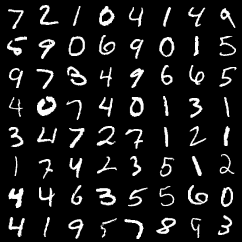

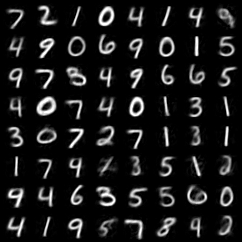

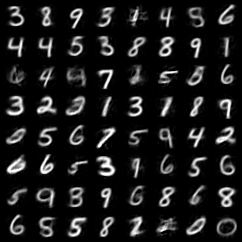

In [9]:
display(Image('./samples/ep50_vae_data.png'))
display(Image('./samples/ep50_vae_recon.png'))
display(Image('./samples/ep50_vae_gen.png'))